# Predicting customers who will "charge-off"

#Define charge-off
Steps:
1. Data Cleaning
2. Feature selection and transformation
3. Build the models
4. Test the models

Before starting: Install the imblearn python package on your computer! 
    
    Run the following in terminal: pip install -U imbalanced-learn

Let's load the libraries, connect to the database, parse dates and load all data in-memory. Make sure the three files database.sqlite, LCDataDictionary.xlsx, and loan.csv are all in the same folder as this notebook.

In [1]:
import sqlite3 #this library manages sql databases
import pandas as pd  #this library enables data manipulation and analysis methods to be used in Python
import numpy as np #this library focuses on scientific computing and using arrays and matrices
%matplotlib inline 
import matplotlib.pyplot as plt #this imports the matplotlib library, along with the interactive plotting pylab module

conn = sqlite3.connect('database.sqlite') # This runs sql within Python; will take a few minutes to run
to_parse = ['issue_d' , 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'] #takes a look at the columns, and cuts them up along columns, extracts columns so we can build a Python dataframe
df = pd.read_sql_query('select * from loan', con=conn, parse_dates = to_parse) #pandas feature, read SQL query into dataframe and load in-memory

In [2]:
df.head() #shows the first few rows of the pandas dataframe we created; allows you to see the variables

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print('The shape is {}'.format(df.shape)) #tells us no of rows and columns of the df
print('Memory : {} Mb'.format(int(df.memory_usage(deep=False).sum() / 1000000))) #tells us how big the df is in Mb

The shape is (887383, 75)
Memory : 532 Mb


That's a fairly large dataframe! Perhaps we can reduce its size without loss by removing cells with little information. (What does "little information" mean?) This will serve to make the dataframe more manageable.

For this first assignment, we will remove columns whose cells are missing more than 60% of their values. 

## Data Cleaning


### Check which features have good coverage, e.g. more/less than N% missing values

In [4]:
#check_null = df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(df))#.isnull() is a pandas feature that checks for missing values
#.sum() is a feature that will sum the previous feature of how many null values, with axis = 0 representing a vertical concatenation, which checks down the column of each dataframe. If axis = 1, this would be a horizontal concatenation checking each row instead of columns
#sort_values will then sort the results, with ascending = False meaning that results will be sorted is a descending order. This is all divided by the length of the dataframe, which has been converted to a float value
#check_null[check_null>0.6] #outputs the feature and fraction of missing values

How many columns have more than 60% missing?

In [5]:
#check_null[check_null>0.6].size #.size is a feature that returns how big a series is. Check_null is a series which checks for how many columns have more than 60% of their values missing, meaning that 20 columns have more than 60% of data missing
#check_null is the overall series we are checking, but we must specify [check_null>0.6] to capture that we are looking for specifically parts of the series that have >60% data missing

In [6]:
df.head() #shows the first few rows of the pandas dataframe we created; allows you to see the variables

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking Features With Little Variation or No Use

A lot of these columns have NaN values, or have little variation. Neither of these will be super useful to us. Let us first look at the columns with little variation, NaN values, and then drop columns we do not need.

1) index
2) policy_code
3) pymnt_plan
4) url
5) id
6) member_id
7) application_type
8) acc_now_delinq
9) emp_title
10) zip_code
11) title

Index is already built into the dataframe, so let us drop it.

#### Exploring Columns with Little Variation

We will now use .groupby to group the dataframe by the specified columns above and sort each column by its values to showcase how much variation these columns have.

In [7]:
#get grouped data
df.groupby('policy_code').size().sort_values()

policy_code
1.0    887382
dtype: int64

In [8]:
#check for variation
np.var(df.filter(regex='policy_code')) #is this testing for the variance of values amongst the specified column
#note that variance only works when checking numbers (int/float), not strings

policy_code    0.0
dtype: float64

An output of 0 means there is no variance, which makes sense as policy_code is always = 1.0.

In [9]:
df.groupby('pymnt_plan').size().sort_values()

pymnt_plan
y        10
n    887372
dtype: int64

In [10]:
unique = []
for x in df.groupby('pymnt_plan').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique))

2


Only 2 different values. For pymnt_plan, only 10 rows take the value "yes", which means there is little useful variation. URL, ID doesn't seem to have any useful information.

In [11]:
df.groupby('application_type').size().sort_values()

application_type
JOINT            511
INDIVIDUAL    886871
dtype: int64

A majority of the applications are indiviudal, with few joint. The little variation here does not help or contribute to our analysis, so this will also be removed. (Alternatively, we could separately analyze the data sets, or just analyze individual applications. Try this at home?)

In [12]:
df.groupby('acc_now_delinq').size().sort_values() # for now, we don't use that variable, but perhaps we can use it in the future?

acc_now_delinq
6.0          1
14.0         1
5.0          3
4.0          7
3.0         28
2.0        208
1.0       3866
0.0     883239
dtype: int64

In [13]:
np.var(df.filter(regex='acc_now_delinq'))

acc_now_delinq    0.006026
dtype: float64

The variance is quite low, meaning that the values are close to each other. Also notice the majority of values are concentrated at 0.0

In [14]:
df.groupby('emp_title').size().sort_values() # for now, we don't use that variable, but perhaps we can use it in the future?

emp_title
 \tAdv Mtr Proj Fld Rep                         1
Risk Systems Analyst                            1
Risk advisory supervisor                        1
Risk analysis                                   1
Risk and Control Analyst II                     1
Risk and Safety Management                      1
Risk consultant                                 1
Risk control                                    1
Risk coordinator                                1
Risk director                                   1
Risk enterprise management                      1
Risk management advisor                         1
Risk management assistant                       1
Risk officer                                    1
Risk System Analyst                             1
Risk services manager                           1
Risk/Control Officer                            1
RiskMetrics Group                               1
Risks and Controls Sr Analyst                   1
Risnychok & Associates, Inc.            

In [15]:
unique = []
for x in df.groupby('emp_title').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique))

456


So there are a lot of different professions here. Perhaps we can use that later.

In [16]:
df.groupby('zip_code').size().sort_values() # for now, we don't use that variable, but perhaps we can use it in the future?

zip_code
649xx       1
643xx       1
862xx       1
621xx       1
817xx       1
849xx       1
819xx       1
507xx       1
509xx       1
682xx       1
511xx       1
513xx       1
514xx       1
516xx       1
520xx       1
569xx       1
568xx       1
429xx       1
524xx       1
889xx       1
694xx       1
892xx       1
399xx       1
375xx       1
901xx       1
909xx       1
742xx       1
205xx       1
938xx       1
888xx       1
         ... 
920xx    4303
956xx    4329
600xx    4518
604xx    4527
021xx    4532
080xx    4539
601xx    4603
481xx    4645
334xx    4744
113xx    4813
925xx    4907
913xx    5161
926xx    5415
852xx    5442
921xx    5661
104xx    6008
117xx    6129
330xx    6283
917xx    6357
891xx    6441
770xx    6938
900xx    7287
331xx    7416
070xx    7431
100xx    7609
300xx    8126
606xx    8641
112xx    9272
750xx    9417
945xx    9770
Length: 935, dtype: int64

In [17]:
unique = []
for x in df.groupby('zip_code').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique))

695


In [18]:
df.groupby('title').size().sort_values() #You could try and check whether people who know how to spell English words are less likely to default

title
Ã®ÂÂÃ®ÂÂMY FIRST CAR Ã®ÂÂÃ®ÂÂ            1
PB&J Wedding                                     1
PCS Simplification                               1
PEACE  OF  MIND                                  1
lower rate for debt consolidation                1
lower rate credit card payoff                    1
lower rate 78                                    1
PEACE of mind                                    1
PEICE OF MIND                                    1
PEPE LOAN                                        1
PERFECTONE                                       1
PAyoff                                           1
PEROSNAL                                         1
lower payments/debt                              1
PERSONAL BILL CONSOLIDATE                        1
PERSONAL BUSINESS                                1
PERSONAL CONSOLIDATE                             1
PERSONAL CONSOLIDATION                           1
PERSONAL CREDIT                                  1
PERSONAL DEBT CONSOLIDATI

In [19]:
unique = []
for x in df.groupby('title').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique))

238


Now that we have gone through the data for the above columns, we can now delete them and columns lacking value:

In [20]:
df.dropna(axis = 1, how = 'all') #vertical concatenation, ensure only dropping columns who have entirely NaN values


,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599.0,5000.0,5000.0,4975.000000,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167.0,2500.0,2500.0,2500.000000,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524.0,2400.0,2400.0,2400.000000,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178.0,10000.0,10000.0,10000.000000,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748.0,3000.0,3000.0,3000.000000,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,1075269,1311441.0,5000.0,5000.0,5000.000000,36 months,7.90%,156.46,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,1069639,1304742.0,7000.0,7000.0,7000.000000,60 months,15.96%,170.08,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,1072053,1288686.0,3000.0,3000.0,3000.000000,36 months,18.64%,109.43,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,1071795,1306957.0,5600.0,5600.0,5600.000000,60 months,21.28%,152.39,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,1071570,1306721.0,5375.0,5375.0,5350.000000,60 months,12.69%,121.45,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To check this worked, let us list the columns now

In [21]:
df.columns        

Index(['index', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verification_sta

Now to specifically remove columns we just checked with little variation or data that does not apply to us right now. 

In [22]:
delete_me = ['index', 'policy_code', 'pymnt_plan', 'url', 'id', 'member_id', 'application_type', 'acc_now_delinq','emp_title', 'zip_code','title']
df.drop(delete_me , axis=1, inplace=True) 

Let's check the columns again!

In [23]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'desc',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', '

Excellent! Now, let's check the basic stats for each column.

In [24]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,887382.000000,887382.000000,887382.000000,887382.000000,8.873780e+05,887382.00000,887353.000000,887353.000000,433069.000000,137053.000000,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171060e+05,21372.000000,21372.000000,21372.000000
mean,14755.280082,14741.893147,14702.480039,436.717647,7.502761e+04,18.15702,0.314445,0.694622,34.063697,70.117903,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206868e+04,0.943945,1.537058,1.977307
std,8435.456408,8429.898507,8442.107612,244.186619,6.469823e+04,17.19060,0.862247,0.998447,21.884941,28.127914,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749833e+04,1.446872,2.723339,2.874067
min,500.000000,500.000000,0.000000,15.670000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,8000.000000,8000.000000,8000.000000,260.710000,4.500000e+04,11.91000,0.000000,0.000000,15.000000,51.000000,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,13000.000000,13000.000000,13000.000000,382.550000,6.500000e+04,17.65000,0.000000,0.000000,31.000000,70.000000,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,20000.000000,20000.000000,20000.000000,572.600000,9.000000e+04,23.95000,0.000000,1.000000,50.000000,92.000000,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000
max,35000.000000,35000.000000,35000.000000,1445.460000,9.500000e+06,9999.00000,39.000000,33.000000,188.000000,129.000000,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


Now, let's check the type of each column.

In [25]:
df.dtypes

loan_amnt                             float64
funded_amnt                           float64
funded_amnt_inv                       float64
term                                   object
int_rate                               object
installment                           float64
grade                                  object
sub_grade                              object
emp_length                             object
home_ownership                         object
annual_inc                            float64
verification_status                    object
issue_d                        datetime64[ns]
loan_status                            object
desc                                   object
purpose                                object
addr_state                             object
dti                                   float64
delinq_2yrs                           float64
earliest_cr_line               datetime64[ns]
inq_last_6mths                        float64
mths_since_last_delinq            

As we can see, there are a variety of data types. Let's clean that up and convert specifcally the datetime64[ns] type into something we can better use.

## Feature transformations

We need to transform a few metrics which sound important, but are formatted as strings.

In [26]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#1. Strip `months` from `term` and strips "month" from e.g. "36 month"
#df['term'] = df['term'].str.split(' ').str[1]

In [28]:
#interest rate is a string. Remove % and make it a float. 
df['int_rate'] = df['int_rate'].str.split('%').str[0]
df['int_rate'] = df.int_rate.astype(float)/100.

In [29]:
df.head() #success

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,5000.0,5000.0,4975.0,36 months,0.1065,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,0.1527,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,0.1596,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,0.1349,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,0.1269,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract numbers from emp_length and fill missing values with the median. (What does that mean? Are there alternative assumptions or procedures we could have used here?)


In [30]:
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)#\d+ extracts the integer
#df['emp_length'] = df['emp_length'].fillna(df.emp_length.median())
df['emp_length'] = df['emp_length'].fillna(0)


Change the format of the datetime

In [31]:
col_dates = df.dtypes[df.dtypes == 'datetime64[ns]'].index
for d in col_dates:
    df[d] = df[d].dt.to_period('M')

In [32]:
df.head() #reload dataframe

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,5000.0,5000.0,4975.0,36 months,0.1065,162.87,B,B2,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,0.1527,59.83,C,C4,1.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,0.1596,84.33,C,C5,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,0.1349,339.31,C,C1,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,0.1269,67.79,B,B5,1.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, to check the types of the dataframe to make sure things worked

In [33]:
df.dtypes

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_length                     float64
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
desc                            object
purpose                         object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line                object
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
revol_bal                

Now we can move onto the modelling!

# Data Modelling

Let's build a model which predicts the status charged_off. (Which question does that answer? Are you perhaps also interested in answering different questions?) Let's first check which fraction of the observations is charged off.

In [34]:
loan_status_grouped = df.groupby('loan_status').size().sort_values(ascending=False)/len(df) * 100
loan_status_grouped

loan_status
Current                                                67.815250
Fully Paid                                             23.408607
Charged Off                                             5.099038
Late (31-120 days)                                      1.306200
Issued                                                  0.953365
In Grace Period                                         0.704656
Late (16-30 days)                                       0.265612
Does not meet the credit policy. Status:Fully Paid      0.224030
Default                                                 0.137370
Does not meet the credit policy. Status:Charged Off     0.085758
dtype: float64

Now we can think of constructing features that are transformation of existing features. (E.g. remember: if you use linear models, you may want to construct variables that allow linear models to fit non-linear relationships along a particular dimension. Think y = x^2.)

* Let's keep the loan_amount, but let's create a metric which indicates that the total amount committed by investors for that loan at that point in time (funded_amnt_inv) is less than what the borrower requested. Perhaps that indicates that other investors aren't super comfortable with the repayment ability?

In [35]:
df['amt_difference'] = 'eq' #set equal as the default value for amt_difference
df.loc[(df['funded_amnt'] - df['funded_amnt_inv']) > 0,'amt_difference'] = 'less'#replaces the value equal with less in case the funded amount is less than requested
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,amt_difference
0,5000.0,5000.0,4975.0,36 months,0.1065,162.87,B,B2,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,less
1,2500.0,2500.0,2500.0,60 months,0.1527,59.83,C,C4,1.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eq
2,2400.0,2400.0,2400.0,36 months,0.1596,84.33,C,C5,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eq
3,10000.0,10000.0,10000.0,36 months,0.1349,339.31,C,C1,10.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eq
4,3000.0,3000.0,3000.0,60 months,0.1269,67.79,B,B5,1.0,RENT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eq



* the metrics `delinq_2yrs` has 80% zeros. Let's make it categorical: `no` when `delinq_2yrs == 0` and `yes` when  `delinq_2yrs > 0`

* Same as above for `inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

* Same as above for `pub_rec`: let's make the number of derogatory public records a binary. (You may play with that and see if we lose information.)

In [36]:
# Turn some continuous variables into binaries

df['delinq_2yrs_cat'] = 'no'
df.loc[df['delinq_2yrs']> 0,'delinq_2yrs_cat'] = 'yes'

df['inq_last_6mths_cat'] = 'no'
df.loc[df['inq_last_6mths']> 0,'inq_last_6mths_cat'] = 'yes'

df['pub_rec_cat'] = 'no'
df.loc[df['pub_rec']> 0,'pub_rec_cat'] = 'yes'

# Create new metric: which fraction of total credit lines is the borrower currently able to still borrow from?
df['acc_ratio'] = df.open_acc / df.total_acc

These are the features we want to use as predictors of charge-off

In [37]:
features = ['loan_amnt', 'amt_difference', 'term', 
            'installment', 'grade','emp_length',
            'home_ownership', 'annual_inc','verification_status',
            'purpose', 'dti', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 
            'open_acc', 'pub_rec', 'pub_rec_cat', 'acc_ratio', 'initial_list_status',  
            'loan_status'
           ]

We want to distinguish between a customer who will *charge off* and a customer who will pay in full. For this iteration of this exercise, we remove borrowers who are current. But that limits our sample in interesting ways. We will reconsider this step in the future.

In [38]:
X_clean = df.loc[df.loan_status != 'Current', features]
X_clean.head()

,loan_amnt,amt_difference,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs_cat,inq_last_6mths_cat,open_acc,pub_rec,pub_rec_cat,acc_ratio,initial_list_status,loan_status
0,5000.0,less,36 months,162.87,B,10.0,RENT,24000.0,Verified,credit_card,27.65,no,yes,3.0,0.0,no,0.333333,f,Fully Paid
1,2500.0,eq,60 months,59.83,C,1.0,RENT,30000.0,Source Verified,car,1.00,no,yes,3.0,0.0,no,0.750000,f,Charged Off
2,2400.0,eq,36 months,84.33,C,10.0,RENT,12252.0,Not Verified,small_business,8.72,no,yes,2.0,0.0,no,0.200000,f,Fully Paid
3,10000.0,eq,36 months,339.31,C,10.0,RENT,49200.0,Source Verified,other,20.00,no,yes,10.0,0.0,no,0.270270,f,Fully Paid
5,5000.0,eq,36 months,156.46,A,3.0,RENT,36000.0,Source Verified,wedding,11.20,no,yes,9.0,0.0,no,0.750000,f,Fully Paid


In [39]:
mask = (X_clean.loan_status == 'Charged Off')
X_clean['target'] = 0
X_clean.loc[mask,'target'] = 1

## A few last touches
We may want to transform categorical variables in continuous variables using the One Hot Encoder. `pandas` has a built-in function for this.

In [40]:
cat_features = ['term','amt_difference', 'grade', 'home_ownership', 'verification_status', 'purpose', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 'pub_rec_cat', 'initial_list_status']

# Drop rows with only missing values
X_clean.dropna(axis=0, how = 'any', inplace = True)

X = pd.get_dummies(X_clean[X_clean.columns[:-2]], columns=cat_features).astype(float)
y = X_clean['target']

## The models

Let's start modelling by importing a few libraries. We must also make sure to standardize all the features and data we are using for the models, in order to reduce quality distillation of our models.

We are importing several modules from sklearn and imblearn which are useful for modelling and analysis.

Regarding scaling, note that many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales. In particular, metric-based and gradient-based estimators often assume approximately standardized data (centered features with unit variances). A notable exception are decision tree-based estimators that are robust to arbitrary scaling of the data.

In [41]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

X_scaled = preprocessing.scale(X)
print(X_scaled)
print('   ')
print(X_scaled.shape)

[[-1.06342482 -1.05092656  1.19699559 ... -0.38225728  0.67045937
  -0.67045937]
 [-1.36792459 -1.46919029 -1.28716645 ... -0.38225728  0.67045937
  -0.67045937]
 [-1.38010458 -1.369739    1.19699559 ... -0.38225728  0.67045937
  -0.67045937]
 ...
 [-0.91421993 -0.81752047 -1.01114844 ... -0.38225728  0.67045937
  -0.67045937]
 [-1.18522473 -1.19819566  1.19699559 ...  2.61603913  0.67045937
  -0.67045937]
 [-0.35089537 -0.09225668 -1.56318445 ... -0.38225728  0.67045937
  -0.67045937]]
   
(285572, 50)


We will now run two models: Logistic Regression and Random Forest.

Through these models we will make predictions and model the roc curve of the estimators. 

In [42]:
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {
            'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10)
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

### Model with unbalanced classes
If we do not modify the class ratios our model has very poor predictive power. The area ander the curve (AUC) is about 0.6, suggesting that we perform better than random. However, the recall is zero: we cannot predict the target variable at all. This might be either because there is something wrong with the metrics or because the classes are too unbalanced. 

computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


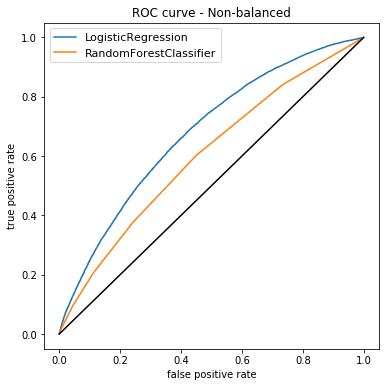

In [43]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')

What does this graph mean? 

In [44]:
models_report #now to get a report of the models

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.023194,0.678623,0.524590,0.00177,0.003527,Non-balanced
1,RandomForestClassifier,0.056080,0.601820,0.306294,0.03633,0.064956,Non-balanced


In [45]:
conf_matrix['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,96116,29
1,18052,32


In [46]:
conf_matrix['RandomForestClassifier'] #the confidence matrix for random forest

Predicted,0,1
True,,
0,94657,1488
1,17427,657
